[View in Colaboratory](https://colab.research.google.com/github/rorycawley/DissertationCA2/blob/master/Rory_Final_Wide_LSTM_(final_charts).ipynb)

**Resets the VM**

In [0]:
#!kill -9 -1

**Installs and environment detection**



In [2]:
!pip show tensorflow

Name: tensorflow
Version: 1.7.0
Summary: TensorFlow helps the tensors flow
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: opensource@google.com
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: astor, wheel, gast, protobuf, grpcio, numpy, tensorboard, termcolor, absl-py, six
Required-by: 


In [3]:
!pip show keras

Name: Keras
Version: 2.1.6
Summary: Deep Learning for humans
Home-page: https://github.com/keras-team/keras
Author: Francois Chollet
Author-email: francois.chollet@gmail.com
License: MIT
Location: /usr/local/lib/python3.6/dist-packages
Requires: h5py, pyyaml, numpy, six, scipy
Required-by: 


In [4]:
!pip install wtte

  Found existing installation: six 1.11.0
    Uninstalling six-1.11.0:
      Successfully uninstalled six-1.11.0


In [5]:
!pip install tqdm

    100% |████████████████████████████████| 51kB 3.7MB/s 


In [6]:
!uname -or

4.4.111+ GNU/Linux


In [7]:
!gcloud version

Google Cloud SDK 199.0.0
alpha 2017.09.15
beta 2017.09.15
bq 2.0.33
core 2018.04.20
gsutil 4.30


In [8]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  #raise SystemError('GPU device not found')
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))
  config = tf.ConfigProto()
  config.gpu_options.allow_growth = True
  print(tf.test.gpu_device_name())

GPU device not found


In [9]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10949176228766087651]

In [10]:
!cat /proc/meminfo

MemTotal:       13341832 kB
MemFree:         1001424 kB
MemAvailable:   12558304 kB
Buffers:          133020 kB
Cached:         11077256 kB
SwapCached:            0 kB
Active:          1983580 kB
Inactive:        9665908 kB
Active(anon):     439584 kB
Inactive(anon):      280 kB
Active(file):    1543996 kB
Inactive(file):  9665628 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              1940 kB
Writeback:             0 kB
AnonPages:        439328 kB
Mapped:           186792 kB
Shmem:               664 kB
Slab:             625120 kB
SReclaimable:     600672 kB
SUnreclaim:        24448 kB
KernelStack:        3200 kB
PageTables:         5420 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6670916 kB
Committed_AS:    1494248 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
AnonHugePages:         0 kB
HugePages_Total: 

In [11]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2200.000
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc eagerfpu pni pclmulqdq ssse3 fma cx16 sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch kaiser fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms rtm rdseed adx smap xsaveopt
bugs		:
bogomips	: 4400.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	: 1
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
micro

In [0]:
def connectWithGDrive():
  !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
  !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
  !apt-get update -qq 2>&1 > /dev/null
  !apt-get -y install -qq google-drive-ocamlfuse fuse
  from google.colab import auth
  auth.authenticate_user()
  from oauth2client.client import GoogleCredentials
  creds = GoogleCredentials.get_application_default()
  import getpass
  !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
  vcode = getpass.getpass()
  !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
  return

# Comment this out if you're already able authed to load and save files
#connectWithGDrive()

#!mkdir -p drive
#!google-drive-ocamlfuse drive

**Import numpy and pandas (to work with the csv file) and matplotlib for visualisation**

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)
PYTHONHASHSEED = 0

**Set column names for the training and test data**

In [14]:
id_col = 'unit_number'
time_col = 'time'
feature_cols = [ 'op_setting_1', 'op_setting_2', 'op_setting_3'] + ['sensor_measurement_{}'.format(x) for x in range(1,22)]
column_names = [id_col, time_col] + feature_cols
column_names

['unit_number',
 'time',
 'op_setting_1',
 'op_setting_2',
 'op_setting_3',
 'sensor_measurement_1',
 'sensor_measurement_2',
 'sensor_measurement_3',
 'sensor_measurement_4',
 'sensor_measurement_5',
 'sensor_measurement_6',
 'sensor_measurement_7',
 'sensor_measurement_8',
 'sensor_measurement_9',
 'sensor_measurement_10',
 'sensor_measurement_11',
 'sensor_measurement_12',
 'sensor_measurement_13',
 'sensor_measurement_14',
 'sensor_measurement_15',
 'sensor_measurement_16',
 'sensor_measurement_17',
 'sensor_measurement_18',
 'sensor_measurement_19',
 'sensor_measurement_20',
 'sensor_measurement_21']

**Use pandas to read in the csv files**

In [0]:
# read training data
#train_orig = pd.read_csv('https://raw.githubusercontent.com/daynebatten/keras-wtte-rnn/master/train.csv', header=None, names=column_names, index_col=['unit_number', 'time'])
train_orig = pd.read_csv('https://raw.githubusercontent.com/daynebatten/keras-wtte-rnn/master/train.csv', header=None, names=column_names)


# read test data
#test_x_orig = pd.read_csv('https://raw.githubusercontent.com/daynebatten/keras-wtte-rnn/master/test_x.csv', header=None, names=column_names, index_col=['unit_number', 'time'])
test_x_orig = pd.read_csv('https://raw.githubusercontent.com/daynebatten/keras-wtte-rnn/master/test_x.csv', header=None, names=column_names)


# read ground truth data
test_y_orig = pd.read_csv('https://raw.githubusercontent.com/daynebatten/keras-wtte-rnn/master/test_y.csv', header=None, names=['T'])

In [16]:
# Change the index to be Engine and Cycle Time
train_orig.set_index(['unit_number', 'time'], verify_integrity=True)
test_x_orig.set_index(['unit_number', 'time'], verify_integrity=True)

op_setting_1  op_setting_2  op_setting_3  \
unit_number time                                             
1           1           0.0023        0.0003         100.0   
            2          -0.0027       -0.0003         100.0   
            3           0.0003        0.0001         100.0   
            4           0.0042        0.0000         100.0   
            5           0.0014        0.0000         100.0   
            6           0.0012        0.0003         100.0   
            7          -0.0000        0.0002         100.0   
            8           0.0006       -0.0000         100.0   
            9          -0.0036        0.0000         100.0   
            10         -0.0025       -0.0001         100.0   
            11          0.0007       -0.0004         100.0   
            12          0.0026        0.0003         100.0   
            13         -0.0056        0.0003         100.0   
            14          0.0017       -0.0004         100.0   
            15         -0.0003       -0.0003         100.0   
            16         -0.0018        0.0003         100.0   
            17          0.0014        0.0002         100.0   
            18          0.0035        0.0001         100.0   
            19          0.0029        0.0001         100.0   
            20          0.0011       -0.0001         100.0   
            21          0.0038       -0.0002         100.0   
            22          0.0012        0.0001         100.0   
            23          0.0009       -0.0000         100.0   
            24         -0.0006       -0.0001         100.0   
            25          0.0028       -0.0003         100.0   
            26          0.0047       -0.0005         100.0   
            27         -0.0007        0.0001         100.0   
            28          0.0022        0.0005         100.0   
            29          0.0014        0.0001         100.0   
            30         -0.0025        0.0004         100.0   
...                        ...           ...           ...   
100         169         0.0026       -0.0000         100.0   
            170        -0.0006       -0.0004         100.0   
            171        -0.0026       -0.0003         100.0   
            172         0.0007        0.0003         100.0   
            173        -0.0003       -0.0000         100.0   
            174        -0.0005        0.0003         100.0   
            175         0.0019        0.0000         100.0   
            176         0.0002        0.0002         100.0   
            177        -0.0041       -0.0003         100.0   
            178         0.0001        0.0005         100.0   
            179         0.0041        0.0001         100.0   
            180        -0.0004        0.0001         100.0   
            181        -0.0010        0.0000         100.0   
            182        -0.0027       -0.0001         100.0   
            183         0.0009        0.0001         100.0   
            184         0.0001       -0.0004         100.0   
            185         0.0032        0.0004         100.0   
            186        -0.0025        0.0005         100.0   
            187         0.0019        0.0002         100.0   
            188         0.0010        0.0005         100.0   
            189        -0.0003        0.0002         100.0   
            190        -0.0038        0.0002         100.0   
            191        -0.0031       -0.0001         100.0   
            192        -0.0034        0.0001         100.0   
            193         0.0018        0.0004         100.0   
            194         0.0049        0.0000         100.0   
            195        -0.0011       -0.0001         100.0   
            196        -0.0006       -0.0003         100.0   
            197        -0.0038        0.0001         100.0   
            198         0.0013        0.0003         100.0   

                  sensor_measurement_1  sensor_measurement_2  \
unit_number time                               

In [17]:
train_orig.head()

,unit_number,time,op_setting_1,op_setting_2,op_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [18]:
test_y_orig.head()

,T
0,112
1,98
2,69
3,82
4,91


In [19]:
train_orig.shape

(20631, 26)

In [20]:
test_x_orig.shape

(13096, 26)

In [21]:
test_y_orig.shape

(100, 1)

**Take a look a some data**

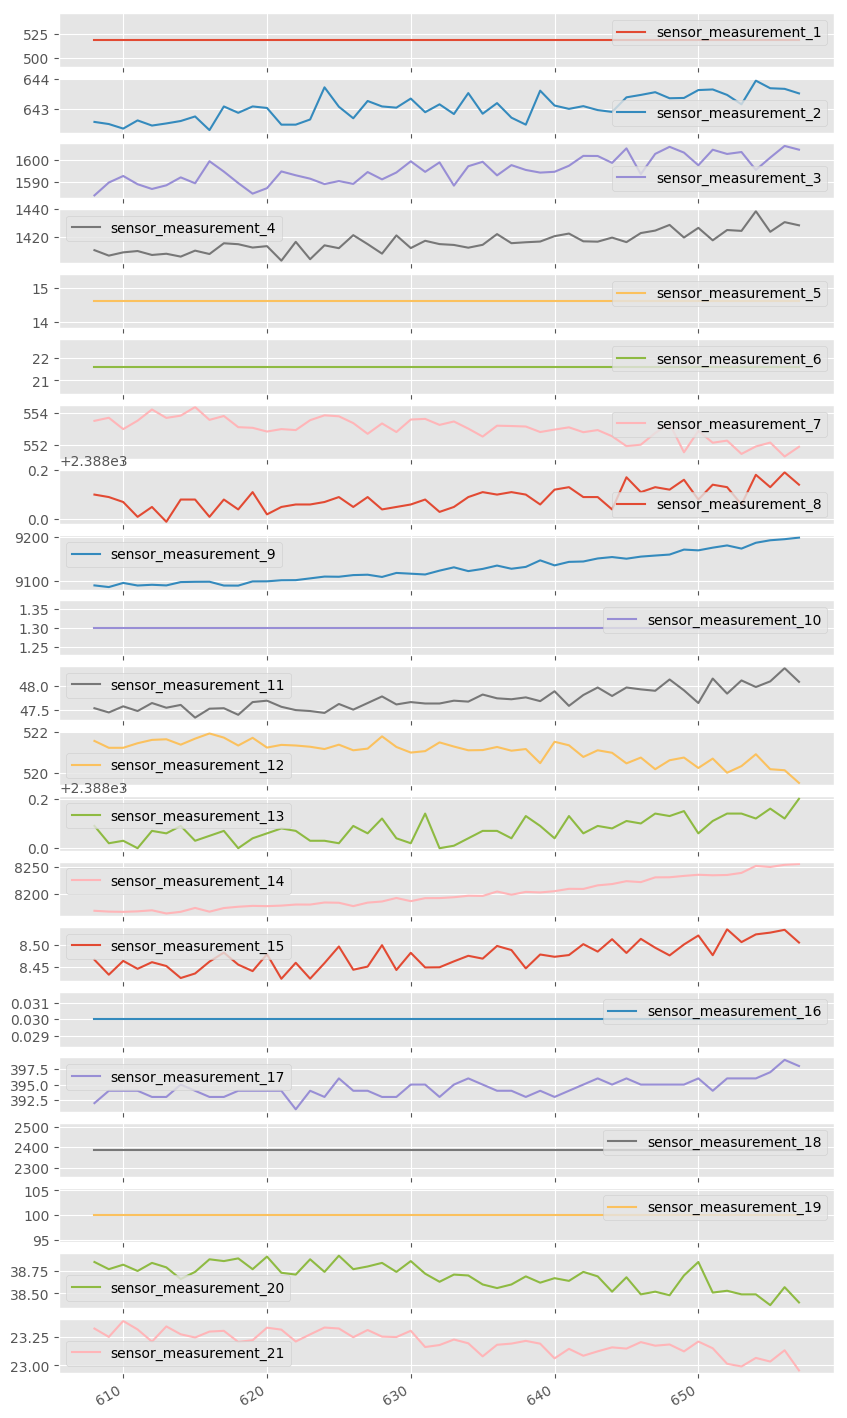

In [99]:
# Take engine 3 from the list of 100 engine sequences
engine_id3 = train_orig.loc[train_orig['unit_number'] == 3]

# Select the final 50 cycles of that engine's life before it fails
engine_id3_50cycleWindow = engine_id3.tail(50)

sensor_cols = [  'sensor_measurement_1',
                 'sensor_measurement_2',
                 'sensor_measurement_3',
                 'sensor_measurement_4',
                 'sensor_measurement_5',
                 'sensor_measurement_6',
                 'sensor_measurement_7',
                 'sensor_measurement_8',
                 'sensor_measurement_9',
                 'sensor_measurement_10',
                 'sensor_measurement_11',
                 'sensor_measurement_12',
                 'sensor_measurement_13',
                 'sensor_measurement_14',
                 'sensor_measurement_15',
                 'sensor_measurement_16',
                 'sensor_measurement_17',
                 'sensor_measurement_18',
                 'sensor_measurement_19',
                 'sensor_measurement_20',
                 'sensor_measurement_21']
# Select only the dynamic sensor readings
engine_id3_50cycleWindow1 = engine_id3_50cycleWindow[sensor_cols]

# plotting sensor data for engine ID 3 prior to a failure point - sensors 1-10 
ax1 = engine_id3_50cycleWindow1.plot(subplots=True, sharex=True, figsize=(10,20))

**Now we scale the data so it's all the same range and it can be processed by the neural network**

In [0]:
from sklearn import pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Combine the X values to normalize them
all_data_orig = pd.concat([train_orig, test_x_orig])

# Use a scale -1 to 1 since that matches our tanh activation function range
scaler = pipeline.Pipeline(steps=[
     ('minmax', MinMaxScaler(feature_range=(-1, 1))),
     ('remove_constant', VarianceThreshold())
])

all_data = all_data_orig.copy()
all_data = np.concatenate([all_data[['unit_number', 'time']], scaler.fit_transform(all_data[feature_cols])], axis=1)


# then split them back out
train = all_data[0:train_orig.shape[0], :]
test = all_data[train_orig.shape[0]:, :]

# Make engine numbers and days zero-indexed, for everybody's sanity
train[:, 0:2] -= 1
test[:, 0:2] -= 1

In [0]:
#df = pd.DataFrame(train)
#df

**Build the data to be processed by the RNN, must be of the format *(batch_size, timesteps, input_features)* instead of *(timesteps, input_features)*  **

In [0]:
import tqdm
from tqdm import tqdm
def build_data(engine, time, x, max_time, is_test, mask_value):
    # y[0] will be days remaining, y[1] will be event indicator, always 1 for this data
    out_y = []
    
    # number of features
    d = x.shape[1]

    # A full history of sensor readings to date for each x
    out_x = []

    # Get the unique number of enginges
    n_engines= np.unique(train[:, 0]).size
    
    for i in tqdm(range(n_engines)):
        # When did the engine fail? (Last day + 1 for train data, irrelevant for test.)
      
        # This gets the highest cycle time for an engine, this is the failure time for training data
        # but not for the test data
        max_engine_time = int(np.max(time[engine == i])) + 1
        #print("Engine " + str(i) + " has max_engine_time " + str(max_engine_time))
        
        # The
        if is_test:
            start = max_engine_time - 1
        else:
            start = 0

        this_x = []

        for j in range(start, max_engine_time):
            # This gets all of the sensor values for the engine i
            engine_x = x[engine == i]

            # This adds the final cycle time to the list
            out_y.append(np.array((max_engine_time - j, 1), ndmin=2))

            xtemp = np.zeros((1, max_time, d))
            xtemp += mask_value
            
            xtemp[:, max_time-min(j, 99)-1:max_time, :] = engine_x[max(0, j-max_time+1):j+1, :]
            this_x.append(xtemp)
            

            
        this_x = np.concatenate(this_x)
        out_x.append(this_x)
    out_x = np.concatenate(out_x)
    out_y = np.concatenate(out_y)
    return out_x, out_y

In [26]:
# This is the current format of the data (timesteps, input_features)
train.shape

(20631, 19)

In [27]:
# # Configurable observation look-back period for each engine/day
max_time = 100
mask_value = -99

# Build the training data 
train_x, train_y = build_data( engine = train[:, 0], time = train[:, 1], x = train[:, 2:], max_time = max_time, is_test = False, mask_value = mask_value)

# Build the test data 
test_x,_ = build_data(engine=test[:, 0], time=test[:, 1], x=test[:, 2:], max_time=max_time, is_test=True, mask_value=mask_value)

# always observed in our case
test_y = test_y_orig.copy()
test_y['E'] = 1

100%|██████████| 100/100 [00:00<00:00, 6563.14it/s]


In [28]:
train_y[:,0]

array([192, 191, 190, ...,   3,   2,   1])

In [29]:
# this is the new format (batch_size, timesteps, input_features)
train_x.shape

(20631, 100, 17)

In [30]:
train_y.shape

(20631, 2)

In [31]:
test_x.shape

(100, 100, 17)

**Initialise the values for the model**

In [32]:
tte_mean_train = np.nanmean(train_y[:,0])
mean_u = np.nanmean(train_y[:,1])

# Initialization value for alpha-bias 
init_alpha = -1.0/np.log(1.0-1.0/(tte_mean_train+1.0) )
init_alpha = init_alpha/mean_u
print('tte_mean_train', tte_mean_train, 'init_alpha: ',init_alpha,'mean uncensored train: ',mean_u)

tte_mean_train 108.80786195530997 init_alpha:  109.30709957832491 mean uncensored train:  1.0


**Start building the model**

In [33]:
import keras.backend as K
from keras.callbacks import History, TerminateOnNaN
from wtte.wtte import WeightWatcher


K.set_epsilon(1e-10)
print('epsilon', K.epsilon())

history = History()
weightwatcher = WeightWatcher()
nanterminator = TerminateOnNaN()

epsilon 1e-10


Using TensorFlow backend.


In [0]:
#saved_model_file = "drive/Colab Notebooks/modelTemplate.json"
saved_model_weights = "drive/Colab Notebooks/model_weightsTemplate.h5"
saved_model_history = "drive/Colab Notebooks/model_historyTemplate.json"

In [0]:
import wtte.wtte as wtte

#from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Masking, Lambda
from keras.optimizers import RMSprop,adam



n_features = train_x.shape[-1]

model = Sequential()

# Mask parts of the lookback period that are all zeros (i.e., unobserved) so they don't skew the model
model.add(Masking(mask_value=mask_value, input_shape=(None, n_features)))
model.add(LSTM(150, activation='tanh', recurrent_dropout=0.25))
model.add(Dense(10,activation='tanh'))

# We need 2 neurons to output Alpha and Beta parameters for our Weibull distribution
model.add(Dense(2))

model.add(Lambda(wtte.output_lambda, 
                 arguments={"init_alpha":init_alpha, 
                            "max_beta_value":100.0, 
                            "alpha_kernel_scalefactor":0.5
                           },
                ))

# Use the discrete log-likelihood for Weibull survival data as our loss function
loss = wtte.loss(kind='discrete',reduce_loss=False).loss_function

model.compile(loss=loss, optimizer=adam(lr=.01, clipvalue=0.5))
#model.compile(loss=loss, optimizer=RMSprop(lr=0.01))

**Train the model to the data**

In [0]:
import time
start = time.time()

In [37]:
load_weights_from_file = False

if load_weights_from_file:
  #print("Recreating a previously saved the model from files")
  
  # Issue in Keras with doing this
  # Model reconstruction from JSON file
  #with open(saved_model_file, 'r') as f:
  #  model = model_from_json(f.read())

  # Load weights into the new model
  print("Loading weights from file")
  model.load_weights(saved_model_weights)
else: 
  model.fit(train_x, train_y,
              epochs=10,
              batch_size=100, 
              verbose=1,
              validation_data=(test_x, test_y),
              callbacks=[nanterminator,history,weightwatcher])

Train on 20631 samples, validate on 100 samples
Epoch 1/10
20631/20631 [==============================] - 67s 3ms/step - loss: 4.7943 - val_loss: 4.2465
Epoch 2/10
20631/20631 [==============================] - 67s 3ms/step - loss: 4.4372 - val_loss: 4.1716
Epoch 3/10
 7100/20631 [=========>....................] - ETA: 43s - loss: 4.3777

20631/20631 [==============================] - 66s 3ms/step - loss: 4.3020 - val_loss: 4.2345
Epoch 4/10
20631/20631 [==============================] - 66s 3ms/step - loss: 4.4200 - val_loss: 4.2851
Epoch 5/10
19200/20631 [==========================>...] - ETA: 4s - loss: 4.2328

20631/20631 [==============================] - 67s 3ms/step - loss: 4.2332 - val_loss: 4.3116
Epoch 6/10
20631/20631 [==============================] - 66s 3ms/step - loss: 4.1183 - val_loss: 4.3591
Epoch 7/10
20631/20631 [==============================] - 65s 3ms/step - loss: 4.0812 - val_loss: 5.3128
Epoch 8/10
 1000/20631 [>.............................] - ETA: 1:02 - loss: 4.1732

20631/20631 [==============================] - 66s 3ms/step - loss: 4.1512 - val_loss: 4.4645
Epoch 9/10
20631/20631 [==============================] - 66s 3ms/step - loss: 4.0737 - val_loss: 4.4694
Epoch 10/10
17600/20631 [========================>.....] - ETA: 9s - loss: 4.0113

20631/20631 [==============================] - 65s 3ms/step - loss: 4.0030 - val_loss: 5.3485


In [38]:
end = time.time()
print(end - start)

663.5177381038666


In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, None, 17)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 150)               75600     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1510      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 22        
_________________________________________________________________
lambda_1 (Lambda)            (None, 2)                 0         
Total params: 77,132
Trainable params: 77,132
Non-trainable params: 0
_________________________________________________________________


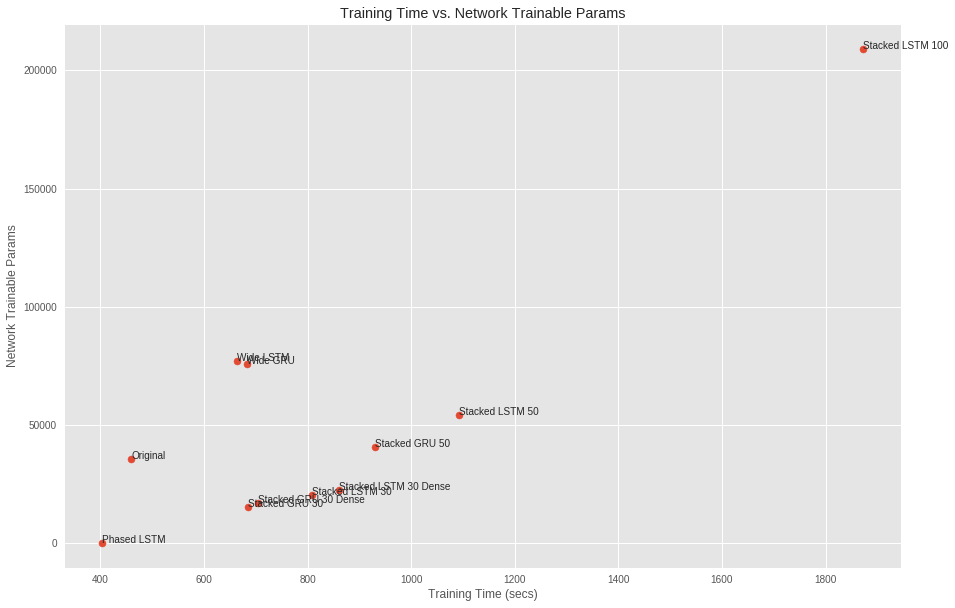

In [15]:
import matplotlib
matplotlib.style.use('ggplot')

# This is a plot to show the training time vs the number of trainable params in the model
models_names = ('Original', 'Wide GRU', 'Wide LSTM', 'Stacked GRU 30', 'Stacked GRU 50', 'Stacked LSTM 30','Stacked LSTM 50', 'Stacked LSTM 100', 'Stacked GRU 30 Dense', 'Stacked LSTM 30 Dense', 'Phased LSTM')
time =   [459,  682,  663, 684, 931, 809, 1092, 1872, 704, 861, 403]
params = [35602,75902, 77132, 15362, 40602, 20462, 54102, 209032, 17222, 22322, 83]

fig, ax = plt.subplots()
ax.scatter(time, params)
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

for i, txt in enumerate(models_names):
    ax.annotate(txt, (time[i],params[i]))
plt.xlabel('Training Time (secs)')
plt.ylabel('Network Trainable Params')
plt.title('Training Time vs. Network Trainable Params')
plt.grid(True)
plt.show()

**Save the model and weights to files**

In [0]:
#import pickle

# there's an issue with keras saving custom layers
#model_json = model.to_json()
#with open("drive/Colab Notebooks/modelTemplate.json", "w") as json_file:
#    json_file.write(model_json)
#    print("Saved model to drive")

# serialize weights to HDF5
#model.save_weights(saved_model_weights)
#print("Saved weights to drive")

#with open(saved_model_history, 'wb') as file_pi:
#    pickle.dump(history.history, file_pi)
#    print("Saved history to drive")


**Show results of the training**

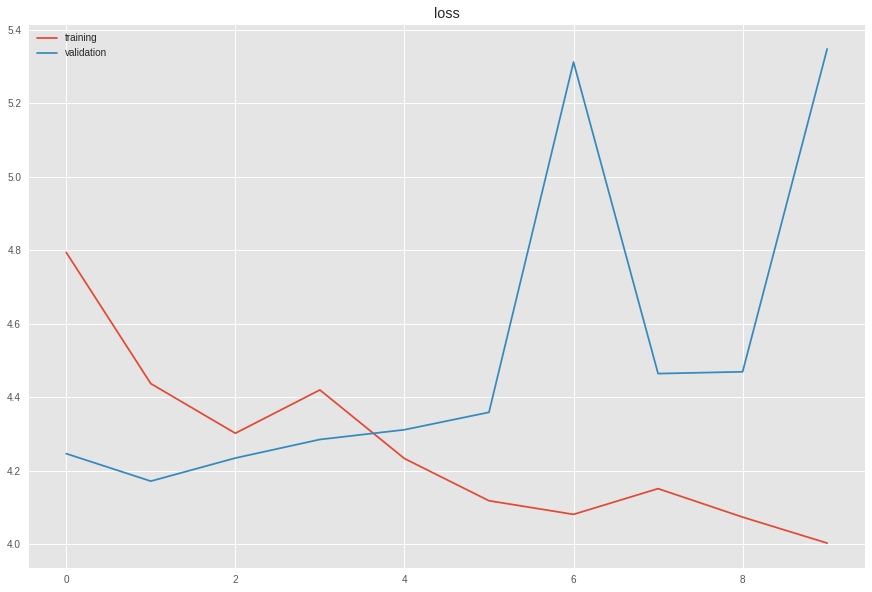

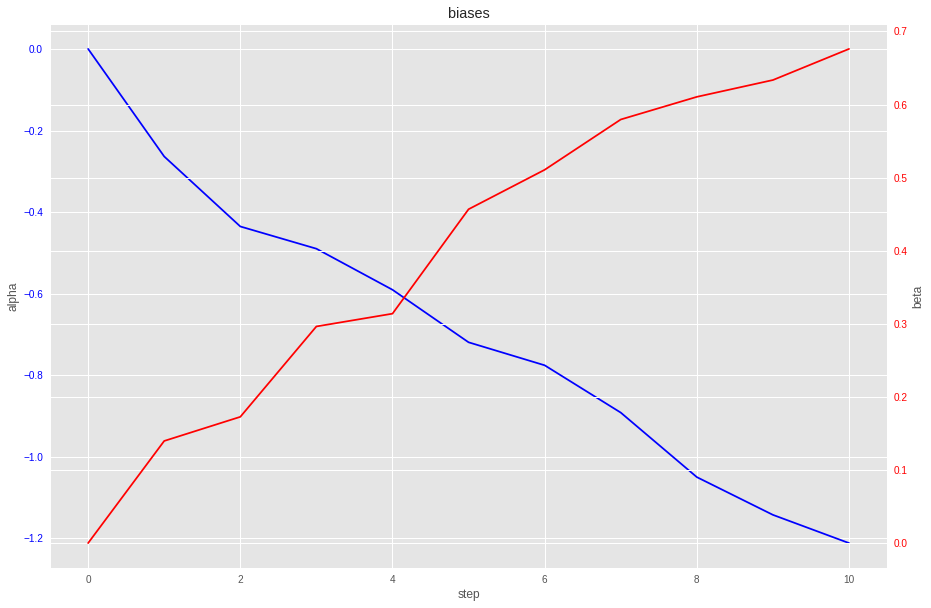

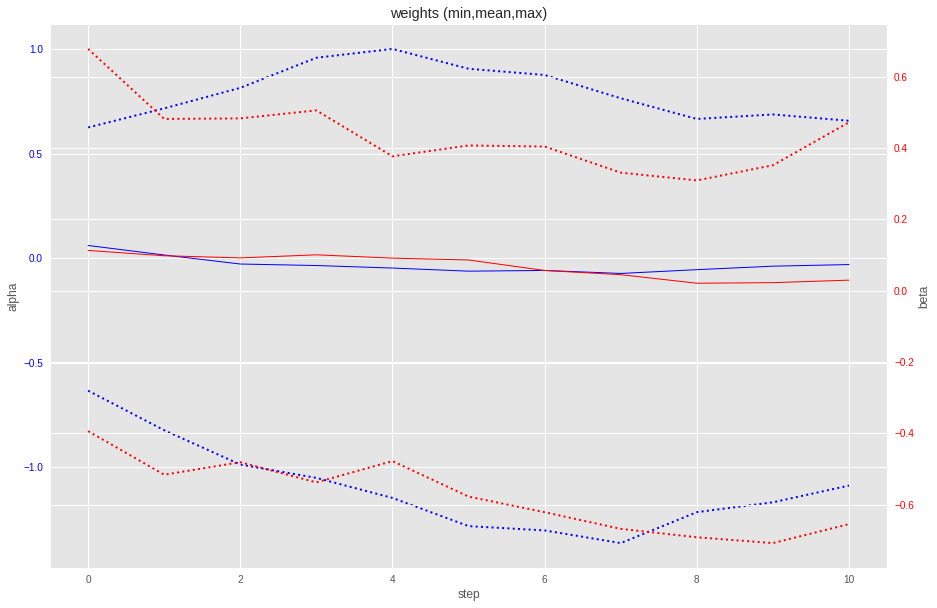

In [41]:
plt.plot(history.history['loss'],    label='training')
plt.plot(history.history['val_loss'],label='validation')
plt.title('loss')
plt.legend()

weightwatcher.plot()

**Use the model to make predictions**

In [0]:
# Make some predictions and put them alongside the real TTE and event indicator values
test_predict = model.predict(test_x)
test_predict = np.resize(test_predict, (100, 2))
test_result = np.concatenate((test_y, test_predict), axis=1)

**Show the accuracy of the prediction by comparing the mode of the distribution with the true value**

In [43]:
# This is the true value
test_y

,T,E
0,112,1
1,98,1
2,69,1
3,82,1
4,91,1
5,93,1
6,91,1
7,95,1
8,111,1
9,96,1


In [44]:
# this is the predicted alpha and beta defining the curve for the distribution
test_predict.shape

(100, 2)

In [45]:
test_predict

array([[216.68123  ,   8.064851 ],
       [134.64197  ,   8.492468 ],
       [ 66.873146 ,   7.7125387],
       [ 98.51494  ,   7.8399405],
       [ 70.89746  ,   7.3257127],
       [ 88.22702  ,   7.6570807],
       [ 95.40012  ,   7.569289 ],
       [ 94.549736 ,   7.5321527],
       [150.30098  ,   8.869224 ],
       [ 75.298775 ,   7.1443253],
       [ 99.32256  ,   8.145187 ],
       [102.11677  ,   7.682542 ],
       [ 85.62496  ,   7.296879 ],
       [147.74355  ,   8.567535 ],
       [111.718544 ,   7.9365263],
       [100.12411  ,   7.619552 ],
       [ 86.82345  ,   7.6487994],
       [ 38.40349  ,   6.8903327],
       [ 81.20024  ,   7.261108 ],
       [ 12.503446 ,   4.9502277],
       [ 84.71365  ,   7.4260607],
       [182.94086  ,   9.20555  ],
       [160.42067  ,   8.843564 ],
       [ 20.883118 ,   8.321357 ],
       [180.74297  ,   8.626385 ],
       [160.66977  ,   8.764732 ],
       [ 78.714134 ,   7.2158685],
       [128.62622  ,   8.34505  ],
       [ 98.12736  ,

In [46]:
test_result.shape

(100, 4)

In [47]:
test_result

array([[112.        ,   1.        , 216.68122864,   8.06485081],
       [ 98.        ,   1.        , 134.64196777,   8.49246788],
       [ 69.        ,   1.        ,  66.87314606,   7.71253872],
       [ 82.        ,   1.        ,  98.51493835,   7.83994055],
       [ 91.        ,   1.        ,  70.89746094,   7.32571268],
       [ 93.        ,   1.        ,  88.22702026,   7.65708065],
       [ 91.        ,   1.        ,  95.4001236 ,   7.56928921],
       [ 95.        ,   1.        ,  94.54973602,   7.53215265],
       [111.        ,   1.        , 150.30097961,   8.86922359],
       [ 96.        ,   1.        ,  75.29877472,   7.14432526],
       [ 97.        ,   1.        ,  99.32256317,   8.14518738],
       [124.        ,   1.        , 102.11676788,   7.68254185],
       [ 95.        ,   1.        ,  85.62496185,   7.29687881],
       [107.        ,   1.        , 147.74354553,   8.5675354 ],
       [ 83.        ,   1.        , 111.71854401,   7.9365263 ],
       [ 84.        ,   1

In [48]:
theTruth = test_y['T'].tolist()
theTruth

[112,
 98,
 69,
 82,
 91,
 93,
 91,
 95,
 111,
 96,
 97,
 124,
 95,
 107,
 83,
 84,
 50,
 28,
 87,
 16,
 57,
 111,
 113,
 20,
 145,
 119,
 66,
 97,
 90,
 115,
 8,
 48,
 106,
 7,
 11,
 19,
 21,
 50,
 142,
 28,
 18,
 10,
 59,
 109,
 114,
 47,
 135,
 92,
 21,
 79,
 114,
 29,
 26,
 97,
 137,
 15,
 103,
 37,
 114,
 100,
 21,
 54,
 72,
 28,
 128,
 14,
 77,
 8,
 121,
 94,
 118,
 50,
 131,
 126,
 113,
 10,
 34,
 107,
 63,
 90,
 8,
 9,
 137,
 58,
 118,
 89,
 116,
 115,
 136,
 28,
 38,
 20,
 85,
 55,
 128,
 137,
 82,
 59,
 117,
 20]

In [49]:
def weibull_pdf(alpha, beta, t):
    return (beta/alpha) * (t/alpha)**(beta-1)*np.exp(- (t/alpha)**beta)

def weibull_median(alpha, beta):
    return alpha*(-np.log(.5))**(1/beta)
  
def weibull_mean(alpha, beta):
    return alpha * math.gamma(1 + 1/beta)
  
def weibull_mode(alpha, beta):
    assert np.all(beta > 1)
    return alpha * ((beta-1)/beta)**(1/beta)
test_results_df = pd.DataFrame(test_result, columns=['T', 'E', 'alpha', 'beta'])

test_results_df['T'].describe()


count    100.00000
mean      75.52000
std       41.76497
min        7.00000
25%       32.75000
50%       86.00000
75%      112.25000
max      145.00000
Name: T, dtype: float64

In [0]:

test_results_df['predicted_mode'] = test_results_df[['alpha', 'beta']].apply(lambda row: weibull_mode(row[0], row[1]), axis=1)
predictedModeValues = test_results_df['predicted_mode'].tolist()

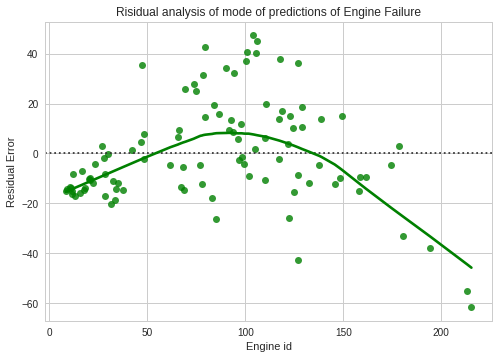

In [51]:
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")

# List of data
prediced_list = predictedModeValues # [10, 20, 10, 50, 30, 40, 40, 33, 49, 10, 10, 50, 30, 40, 40, 10, 20, 10, 50, 30, 40, 40, 33, 49, 10, 10 ]
truth_list =  theTruth #  [13, 18, 13, 40, 33, 42, 41, 30, 30, 40, 13, 15, 13, 40, 20, 13, 40, 33, 49, 10, 50, 30, 40, 13, 15, 13 ]
predictions = np.array(prediced_list)
test = np.array(truth_list)

# Plot the residuals after fitting a linear model
r_ax = sns.residplot(predictions, test, lowess=True, color="g")
r_ax.set(ylabel='Residual Error', xlabel='Engine id')
plt.title('Risidual analysis of mode of predictions of Engine Failure')

plt.show()

In [52]:
# To compare the different models I use RMSE
# http://hamelg.blogspot.ie/2015/11/python-for-data-analysis-part-27-linear.html
# Root mean squared error (RMSE) is a common evaluation metric for predictions 
# involving real numbers. Root mean squared error is square root of the average of the squared error (residuals.). 

from sklearn.metrics import mean_squared_error

def rmse(predicted, targets):
    """
    Computes root mean squared error of two numpy ndarrays
    
    Args:
        predicted: an ndarray of predictions
        targets: an ndarray of target values
    
    Returns:
        The root mean squared error as a float
    """
    # use the scikit-learn library's mean squared error function and take the square root of the result
    return mean_squared_error(predicted, targets)**0.5

rmse(predictions, test)

26.898959290987616

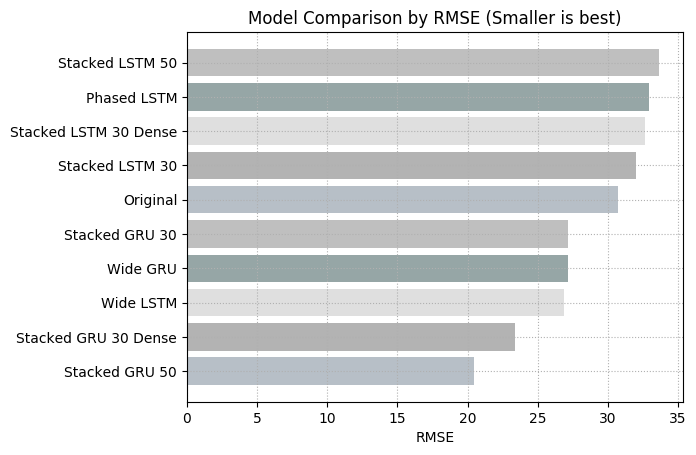

In [16]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
#matplotlib.style.use('ggplot')

 
colors = ['#708090', '#696969', '#C0C0C0', '#2F4F4F', '#808080']

objects = (        
'Stacked GRU 50',
'Stacked GRU 30 Dense',
'Wide LSTM',
'Wide GRU',
'Stacked GRU 30',
'Original',
'Stacked LSTM 30',
'Stacked LSTM 30 Dense',
'Phased LSTM',
'Stacked LSTM 50')
y_pos = np.arange(len(objects))
performance = [        
 20.43,
 23.34,
26.89,
27.12,
 27.18,
 30.69,
32,
32.65,
 32.89,
  33.66]
plt.barh(y_pos, performance, align='center', alpha=0.5,color=colors)
plt.yticks(y_pos, objects)
plt.xlabel('RMSE')
plt.title('Model Comparison by RMSE (Smaller is best)')
plt.grid(linestyle='dotted')

plt.show()

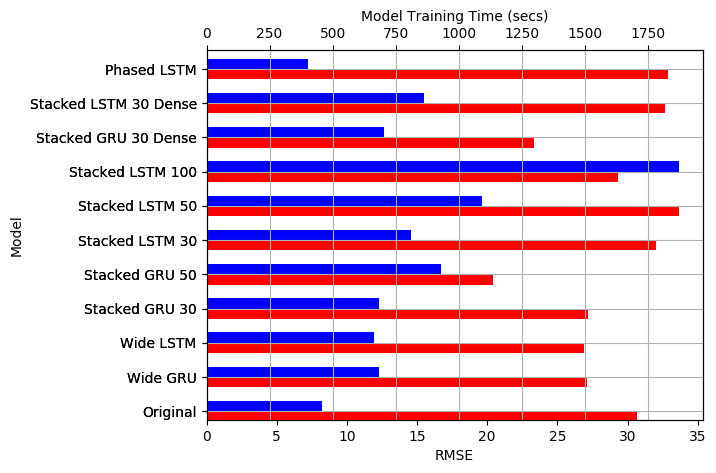

In [17]:
objects = ('Original', 'Wide GRU', 'Wide LSTM', 'Stacked GRU 30', 'Stacked GRU 50', 'Stacked LSTM 30', 'Stacked LSTM 50','Stacked LSTM 100', 'Stacked GRU 30 Dense', 'Stacked LSTM 30 Dense', 'Phased LSTM')
performance = [ 30.69, 27.12, 26.89, 27.18, 20.43, 32, 33.66, 29.32, 23.34, 32.65, 32.89 ]
time =   [459,  682,  663, 684, 931, 809, 1092, 1872, 704, 861, 403]

dfGraph = pd.DataFrame(list(map(list, zip(objects,performance,time))))

dfGraph = pd.DataFrame(list(zip(objects,performance,time)),
              columns=['Title','RMSE', 'Time'])
#dfGraph

fig = plt.figure() # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twiny() # Create another axes that shares the same x-axis as ax.

width = 0.3

dfGraph.RMSE.plot(kind='barh', color='red', ax=ax, width=width, position=1)
dfGraph.Time.plot(kind='barh', color='blue', ax=ax2, width=width, position=0)
ax.set_yticklabels(dfGraph.Title)
#ax.legend((rects1[0], rects2[0]), ('Men', 'Women'))
#ax.legend(('RMSE'),loc=5)
#ax2.legend(('Time'),loc=5)


ax.set_ylabel('Model')
ax.set_xlabel('RMSE')
ax2.set_xlabel('Model Training Time (secs)')
plt.grid(True)
plt.show()

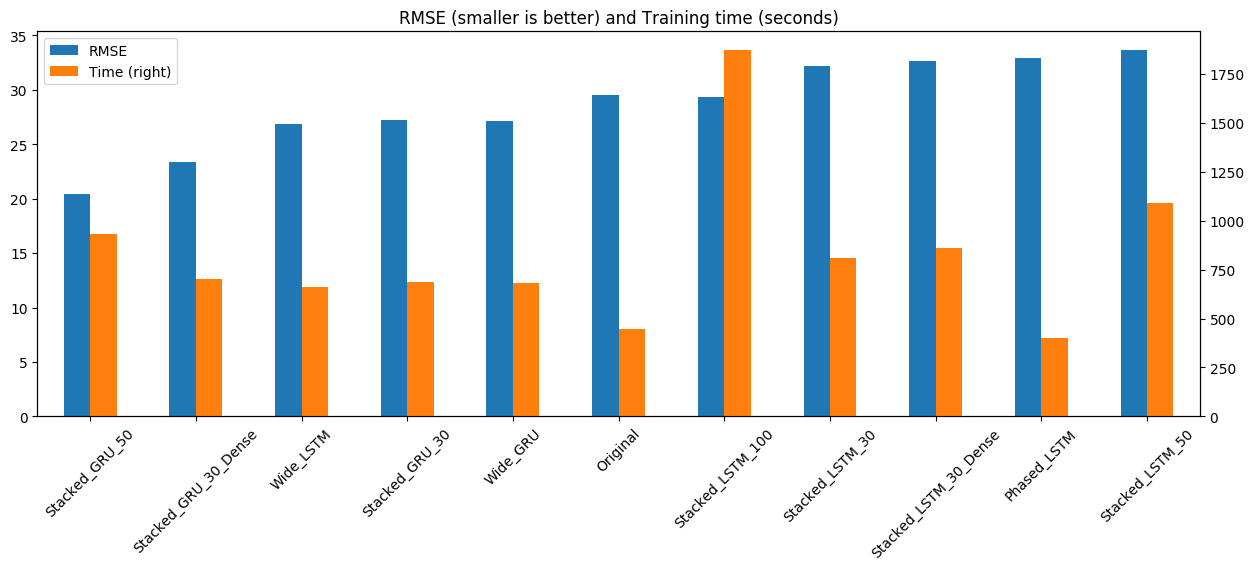

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from io import StringIO
s = StringIO("""     RMSE     Time
Stacked_GRU_50    20.43  931
Stacked_GRU_30_Dense     23.34   704
Wide_LSTM 26.89 663
Stacked_GRU_30    27.18  684
Wide_GRU     27.12   682
Original     29.53   448
Stacked_LSTM_100    29.32  1872
Stacked_LSTM_30    32.21  809
Stacked_LSTM_30_Dense     32.65   861
Phased_LSTM 32.89 403
Stacked_LSTM_50    33.66  1092""")
df = pd.read_csv(s, index_col=0, delimiter=' ', skipinitialspace=True)


objects = ('Original', 'Wide GRU', 'Wide LSTM', 'Stacked GRU 30', 'Stacked GRU 50', 'Stacked LSTM 30', 'Stacked LSTM 50','Stacked LSTM 100', 'Stacked GRU 30 Dense', 'Stacked LSTM 30 Dense', 'Phased LSTM')
performance = [ 30.69, 27.12, 26.89, 27.18, 20.43, 32, 33.66, 29.32, 23.34, 32.65, 32.89  ]
time =   [459,  682,  663, 684, 931, 809, 1092, 1872, 704, 861, 403]
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5
_ = df.plot( kind= 'bar' , secondary_y= 'Time' , rot= 45, title='RMSE (smaller is better) and Training time (seconds)')

plt.xlabel('xlabel', fontsize=18)

plt.show()

In [0]:
test_results_df['unit_number'] = np.arange(1, test_results_df.shape[0]+1)

In [58]:
test_results_df

,T,E,alpha,beta,predicted_mode,unit_number
0,112.0,1.0,216.681229,8.064851,213.153472,1
1,98.0,1.0,134.641968,8.492468,132.670300,2
2,69.0,1.0,66.873146,7.712539,65.679819,3
3,82.0,1.0,98.514938,7.839941,96.815146,4
4,91.0,1.0,70.897461,7.325713,69.491193,5
5,93.0,1.0,88.227020,7.657081,86.629127,6
6,91.0,1.0,95.400124,7.569289,93.630890,7
7,95.0,1.0,94.549736,7.532153,92.778460,8
8,111.0,1.0,150.300980,8.869224,148.287334,9
9,96.0,1.0,75.298775,7.144325,73.726159,10


alpha 85.57852083206177 beta 7.457403388023376


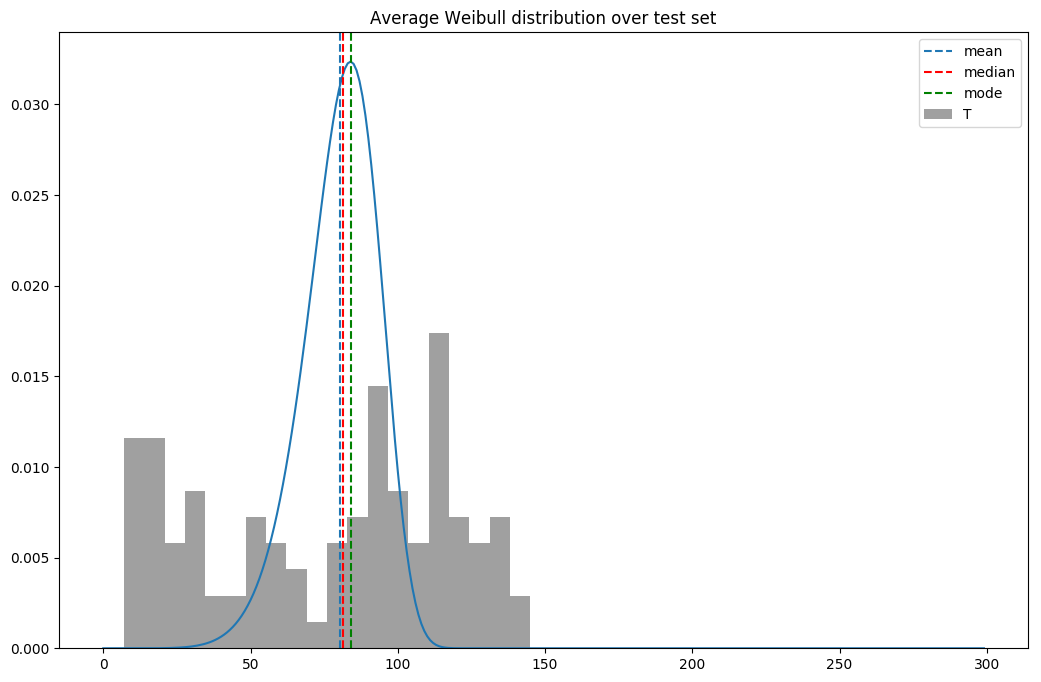

In [59]:
import math

t=np.arange(0,300)
alpha = test_results_df['alpha'].mean()
beta = test_results_df['beta'].mean()

plt.plot(t, weibull_pdf(alpha,beta, t))
mu = weibull_mean(alpha, beta)
median =weibull_median(alpha, beta)
mode = weibull_mode(alpha, beta)
plt.axvline(mu, ls='--', label='mean')
plt.axvline(median, ls='--', color='red', label='median')
plt.axvline(mode, ls='--', color='green', label='mode')
n, bins, patches = plt.hist(test_results_df['T'], 20, normed=1, facecolor='grey', alpha=0.75, label='T')
plt.legend()

plt.gcf().set_size_inches(12.5, 8)
plt.title('Average Weibull distribution over test set')
print('alpha', alpha, 'beta', beta)

In [0]:
def plot_weibull_predictions(results_df):

    fig, axarr = plt.subplots(3, figsize=(20,30))

    t=np.arange(0,400)
#palette=sns.color_palette("Blues")
    flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
#sns.palplot(sns.color_palette(flatui))

#    palette = sns.color_palette("RdBu_r", results_df.shape[0] + 1)
    palette = sns.color_palette(flatui, results_df.shape[0] + 1)
    color_dict = dict(enumerate(palette))

    for i, row in enumerate(results_df.iterrows()):
        alpha=row[1]['alpha']
        beta = row[1]['beta']
        T = row[1]['T']
        label = 'a={} b={}'.format(alpha, beta)

        color = color_dict[i]
        ax= axarr[0]
        mode = weibull_mode(alpha, beta)
        y_max = weibull_pdf(alpha, beta, mode)    

        ax.plot(t, weibull_pdf(alpha, beta, t), color=color, label=label)
        ax.scatter(T, weibull_pdf(alpha,beta, T), color=color, s=100)
        ax.vlines(mode, ymin=0, ymax=y_max, colors=color, linestyles='--')

        ax.set_title('Weibull distributions')
    
    ax=axarr[1]
    
    median_predictions = weibull_median(results_df['alpha'], results_df['beta'])
    mean_predictions = results_df[['alpha', 'beta']].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)
    mode_predictions = weibull_mode(results_df['alpha'], results_df['beta'])
#     x = results_df['time']
    
#     ax.scatter(x, results_df['T'], label='survival_time', color='black')

#     ax.scatter(results_df['T'], median_predictions, label='median_prediction')
#     ax.scatter(results_df['T'], mean_predictions, label='mean_prediction')
    ax.scatter(results_df['T'], mode_predictions, label='m_prediction')
    ax.set_title('MAP prediction Vs. true')
    

    ax.legend()
    
    ax=axarr[2]
    sns.distplot(results_df['T'] - mode_predictions, ax=ax)
    ax.set_title('Error')

#     ax.plot(x, results_df['alpha'], label='alpha')
#     ax.legend()
    
#     ax = axarr[3]
#     ax.plot(x, results_df['beta'], label='beta')
#     ax.legend()
    
#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     fig.suptitle(title)
    plt.show()

In [61]:
train_orig.describe()

,unit_number,time,op_setting_1,op_setting_2,op_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,0.737553,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [62]:
test_results_df.head()
test_results_df.loc[test_results_df['unit_number'] == 1]


,T,E,alpha,beta,predicted_mode,unit_number
0,112.0,1.0,216.681229,8.064851,213.153472,1


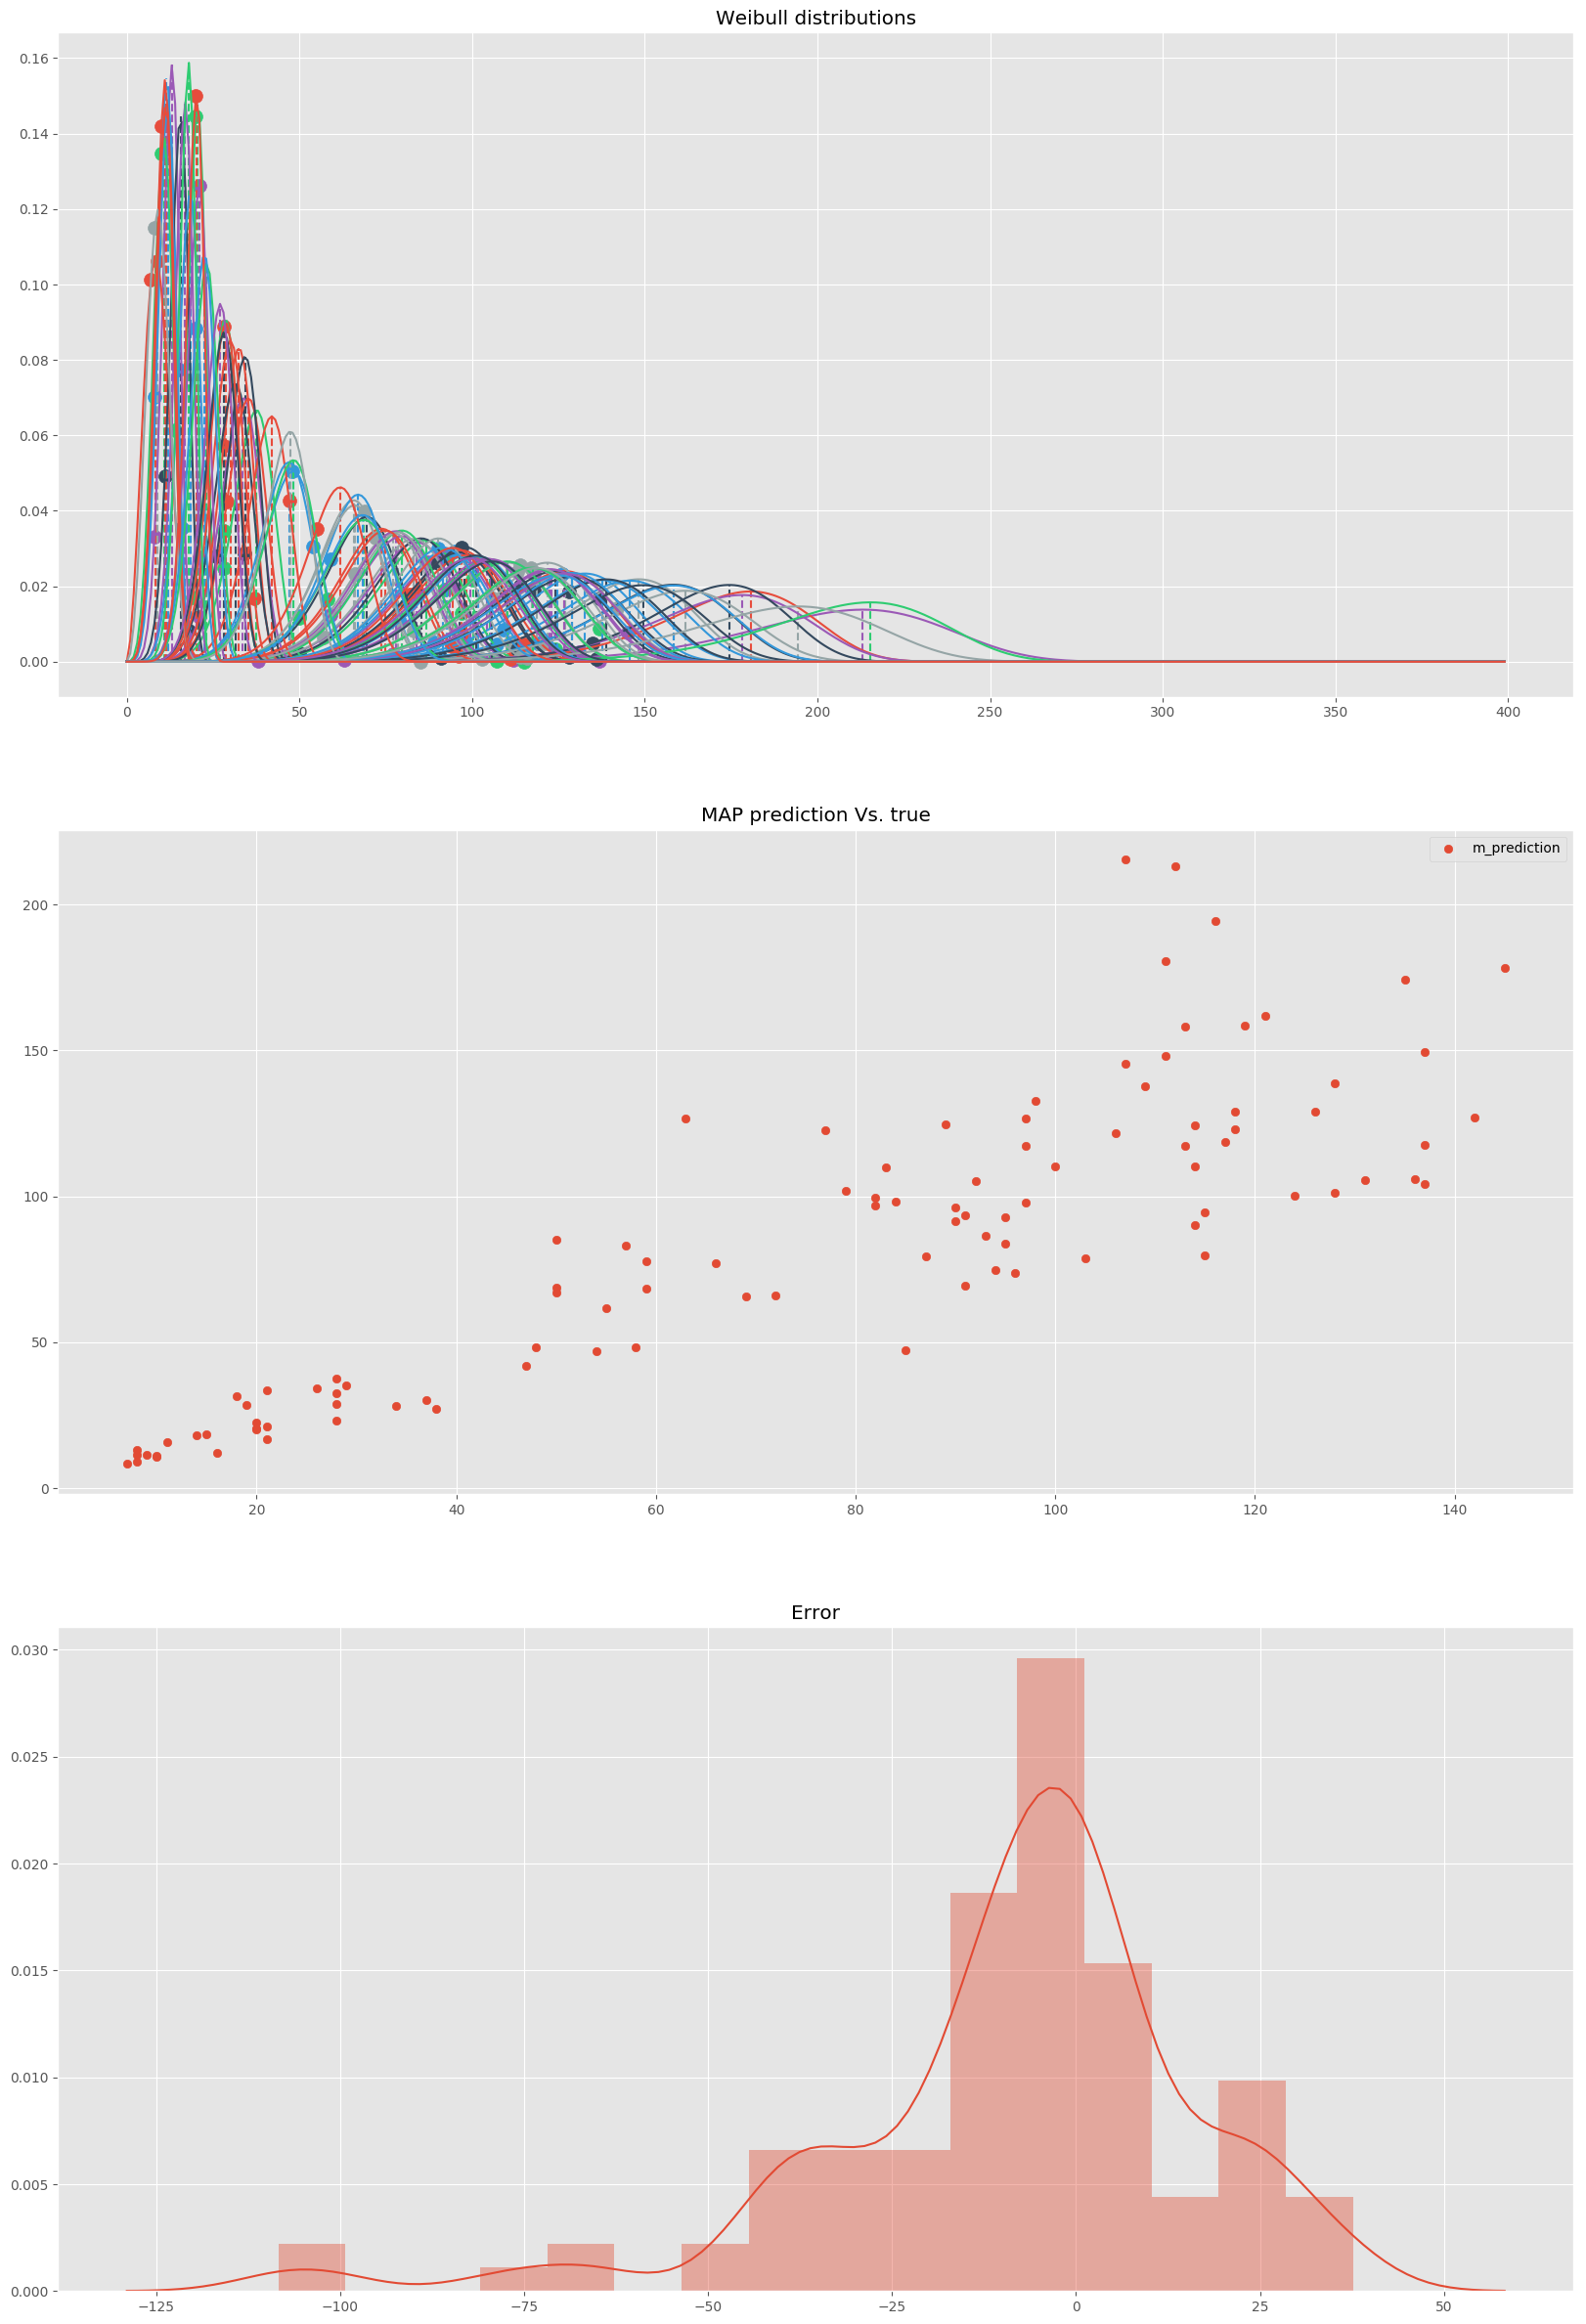

In [103]:
import seaborn as sns

plot_weibull_predictions(test_results_df)

In [0]:
test_results_df['predicted_mu'] = test_results_df[['alpha', 'beta']].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)
test_results_df['predicted_median'] = test_results_df[['alpha', 'beta']].apply(lambda row: weibull_median(row[0], row[1]), axis=1)
test_results_df['predicted_mode'] = test_results_df[['alpha', 'beta']].apply(lambda row: weibull_mode(row[0], row[1]), axis=1)

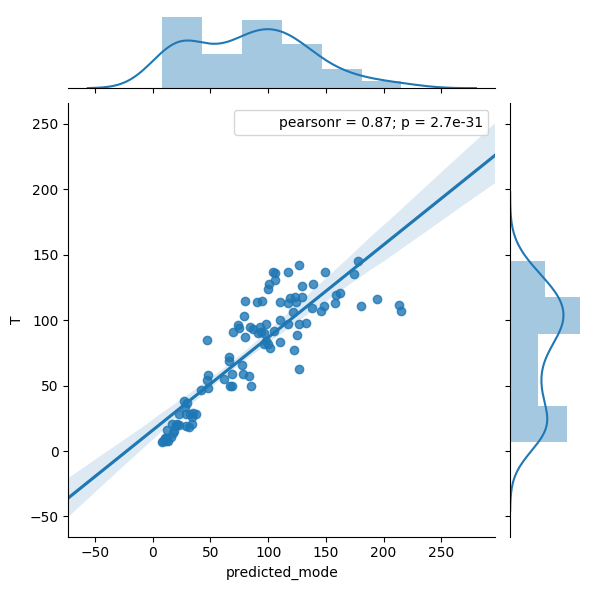

In [65]:
import seaborn as sns
sns.jointplot(data=test_results_df, y='T', x='predicted_mode',kind="reg")

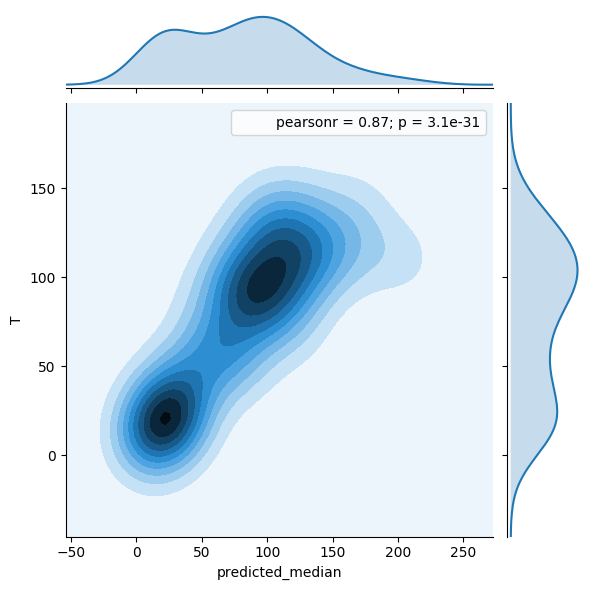

In [66]:
sns.jointplot(data=test_results_df, y='T', x='predicted_median',kind="kde" )

In [67]:
test_results_df['error'] = test_results_df['T']-test_results_df['predicted_median']
test_results_df['error'].describe()

count    100.000000
mean      -6.167523
std       24.851827
min     -102.572981
25%      -14.668263
50%       -3.034251
75%        6.353533
max       38.992465
Name: error, dtype: float64

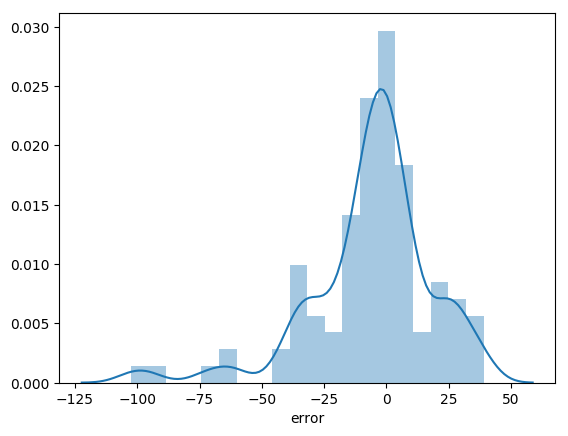

In [68]:
sns.distplot(test_results_df['error'], bins=20)

**Training evaluation**

In [69]:
test_y.shape


(100, 2)

In [70]:
train_y.shape


(20631, 2)

In [0]:
train_predict=model.predict(train_x)


In [0]:
train_predict = np.resize(train_predict, (20631, 2))
train_result = np.concatenate((train_y, train_predict), axis=1)

In [73]:
train_predict.shape


(20631, 2)

In [0]:
train_results_df = pd.DataFrame(train_result, columns=['T', 'E', 'alpha', 'beta'])


In [0]:
train_results_df[['unit_number', 'time']] = train_orig[['unit_number', 'time']]


In [76]:
train_results_df['unit_number'].nunique()


100

In [77]:
train_results_df.shape


(20631, 6)

In [78]:
train_results_df.groupby('unit_number')['beta'].describe()


,count,mean,std,min,25%,50%,75%,max
unit_number,,,,,,,,
1,192.0,7.041894,1.224332,1.278157,6.678883,7.356253,7.708686,8.434570
2,287.0,7.756323,1.417276,1.279307,7.285410,7.986247,8.663705,9.443227
3,179.0,7.391031,1.306147,1.278534,6.991451,7.563845,8.141896,8.780515
4,189.0,7.483297,1.627028,1.278055,7.216883,7.746907,8.382485,9.143845
5,269.0,7.772889,1.316155,1.283373,7.422903,8.008332,8.568469,9.340893
6,188.0,7.775201,1.589221,1.277987,7.387687,8.123079,8.763936,9.578887
7,259.0,7.612734,1.435805,1.279119,7.188447,7.715341,8.609472,9.381822
8,150.0,7.270526,1.538331,1.278068,7.178243,7.681764,8.089207,8.915339
9,201.0,7.541296,1.253261,1.251996,7.141307,7.841929,8.232895,8.831880


In [0]:
#for unit_number, grp in train_results_df.groupby('unit_number'):
    #plot_weibull_predictions(grp)
 #       plot_weibull_predictions(grp, unit_number)

In [0]:
train_results_df['predicted_mu'] = train_results_df[['alpha', 'beta']].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)
train_results_df['predicted_median'] = train_results_df[['alpha', 'beta']].apply(lambda row: weibull_median(row[0], row[1]), axis=1)

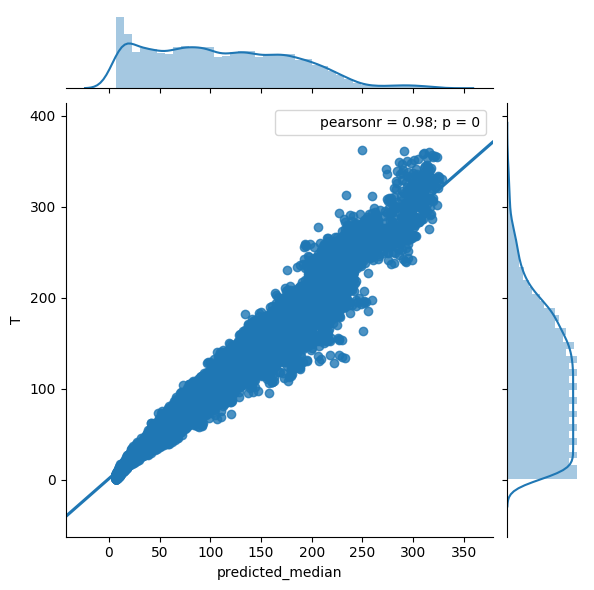

In [81]:
sns.jointplot(data=train_results_df, y='T', x='predicted_median',kind="reg")

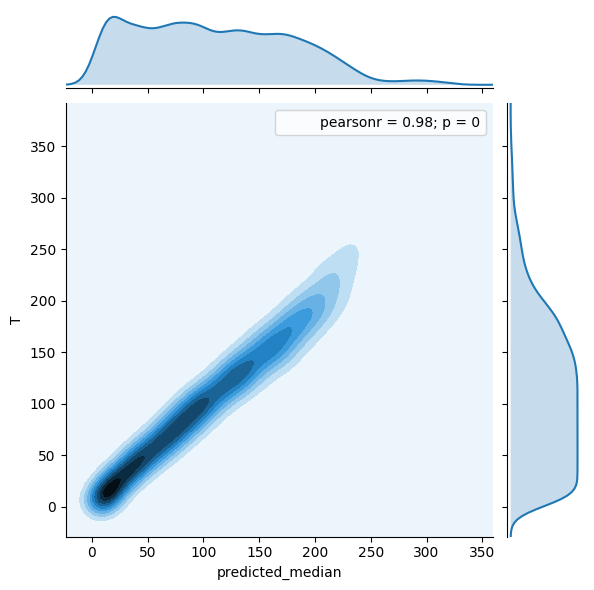

In [82]:
sns.jointplot(data=train_results_df, y='T', x='predicted_median',kind="kde" )


In [83]:
train_results_df['error'] = train_results_df['T']-train_results_df['predicted_median']
train_results_df['error'].describe()


count    20631.000000
mean        -1.239904
std         12.293335
min        -99.158994
25%         -6.373996
50%         -0.363385
75%          5.037060
max        112.121872
Name: error, dtype: float64

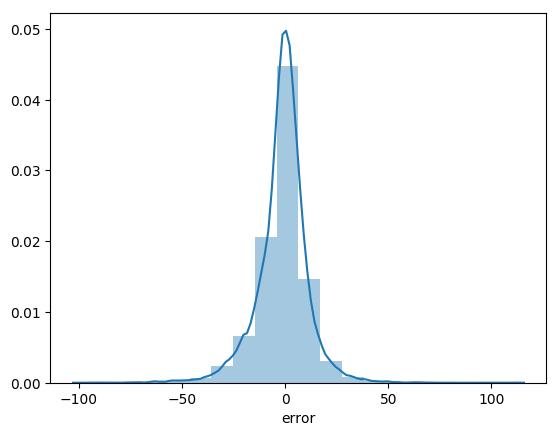

In [84]:
sns.distplot(train_results_df['error'], bins=20)
